<a href="https://colab.research.google.com/github/ciaransoleary/UCDPA_ciaran_oleary/blob/main/StudentRetention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Retention
This notebook contains the code for an analysis on student retention data, as described in the accompanying report.

# Import Statements
The various required packages are imported at the start.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Import Data
Two data files are now imported into dataframes. These actually originated in a single files, but I split them to meet the learning outcomes for this project. The distinct patterns in six columns with binary values were each labelled seprately and stored in "profilevalues.csv". The remainder of the data, with the inciator for the pattern in the other file, is stored in "dropoutdataprofileindicator.csv".

In [ ]:
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/data/'
dropoutdatawithprofileindicator = pd.read_csv(data_folder + 'dropoutdataprofileindicator.csv')
profilevalues = pd.read_csv(data_folder + 'profilevalues.csv')

Mounted at /content/drive


# Create Reusable Function
This reusable function provides descriptive information about data frames that are passed as parameters.

In [ ]:
def print_dataframe_details(df_name = "Unnamed", dataframe=None):
	print("")
	print(df_name)
	print(dataframe.shape)
	print(dataframe.dtypes)


# Describe both Data Frames
Using the function.

In [ ]:
print_dataframe_details("Drop Out Data", dropoutdatawithprofileindicator)
print_dataframe_details("Profile Values", profilevalues)


Drop Out Data
(4424, 32)
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Profile                                            object
Age at enrollment                                   int64
International                                       int64
Curricular units 1st sem (credited)           

# Set Data as Categorical
The identified columns in the "dropoutdatawithprofileindicator" data frame are retyped as categorical.

All six columns in the "profilevalues" dataframe are set as categorical.

In [ ]:
for i in ["Marital status",
			"Application mode",
			"Application order",
			"Course",
			"Daytime/evening attendance",
			"Previous qualification",
			"Nacionality",
			"Mother's qualification",
			"Father's qualification",
			"Mother's occupation",
			"Father's occupation",
			"International",
			"Target"]:
    dropoutdatawithprofileindicator[i] = dropoutdatawithprofileindicator[i].astype('category')

profilevalues = profilevalues.iloc[:, 0:len(profilevalues.columns)].astype("category")

# Merge Both Data Frames
An inner join is used to merge the two dataframes. This results in a new dataframe called dropoutdata.

The column used to join both dataframes is dropped.


In [ ]:
dropoutdata = dropoutdatawithprofileindicator.merge(profilevalues, left_on="Profile", right_on="Profile Indicator")
dropoutdata = dropoutdata.drop(["Profile Indicator"], axis=1)
dropoutdata = dropoutdata.drop(["Profile"], axis=1)


# Check for Missing Values
This finds that there are no missing values.

In [ ]:
print(dropoutdata.isnull().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Age at enrollment                                 0
International                                     0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular u

# Simulate Missing Data
As there was no data missing in the data set, some columns are chosen at random for a random number of random entries to be set to null. This makes use of numpy's random number generator which is seeded with a value for consistency.

In [ ]:
# Create random number generator
rng = np.random.default_rng(28062023)

# Choose the number of columns to set to have missing values
number_of_columns_to_set_to_include_missing_values = int(rng.random() * (len(dropoutdata.columns) - 1))

# Create a list of the columns that will be updated to have missing values
columns_to_set_to_include_missing_values = (rng.random(size = number_of_columns_to_set_to_include_missing_values) * (len(dropoutdata.columns) - 1))
columns_to_set_to_include_missing_values = list(map(lambda x: int(x), columns_to_set_to_include_missing_values))

# Limit the number of mising values to 1% of the values in the column
max_number_of_values_to_set_to_missing_in_any_column = int(rng.random() * (len(dropoutdata) / 100))

# Generate a list with the number of missing values for each column
number_of_values_to_set_to_missing_in_identified_columns = []
for i in range(0, number_of_columns_to_set_to_include_missing_values):
	number_of_values_to_set_to_missing_in_identified_columns.append(int(rng.random() * max_number_of_values_to_set_to_missing_in_any_column))

# Locate the columns, generate the row numbers for the entries to be set to null, and set them to null
for i in range(0, number_of_columns_to_set_to_include_missing_values):
	for j in range(0, number_of_values_to_set_to_missing_in_identified_columns[i]):
		row_index_for_this_column_to_set_to_missing = int(rng.random() * (len(dropoutdata) - 1))
		dropoutdata.iloc[row_index_for_this_column_to_set_to_missing, columns_to_set_to_include_missing_values[i]] = np.NAN


# Check Again for Missing Values
This time missing values are shown for several columns. Obviously this reduces the integrity of the data set, but it provides an opportunity to show how missing values will be dealt with.

In [ ]:
print(dropoutdata.isnull().sum())

Marital status                                     0
Application mode                                  23
Application order                                 24
Course                                             0
Daytime/evening attendance                        24
Previous qualification                             0
Previous qualification (grade)                     0
Nacionality                                        0
Mother's qualification                             0
Father's qualification                            28
Mother's occupation                                0
Father's occupation                               29
Admission grade                                    0
Age at enrollment                                  0
International                                     27
Curricular units 1st sem (credited)                0
Curricular units 1st sem (enrolled)                5
Curricular units 1st sem (evaluations)             0
Curricular units 1st sem (approved)           

# Impute Values for Missing Values
In the case of categorical data, the mode is used.
In the case of numerical data, the mean is used.

In [ ]:
columns_with_missing_values = dropoutdata.columns[dropoutdata.isna().any()]

for col in columns_with_missing_values:
	if(dropoutdata[col].dtype == "category"):
		dropoutdata[col].fillna(dropoutdata[col].value_counts().index[0], inplace = True)
	elif (dropoutdata[col].dtype == "int64" or dropoutdata[col].dtype == "float64"):
		dropoutdata[col].fillna(dropoutdata[col].mean(), inplace = True)

# Confirm Absence of Missing Values
Once again, there are no missing vlaues.

In [ ]:
print(dropoutdata.isnull().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Age at enrollment                                 0
International                                     0
Curricular units 1st sem (credited)               0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (approved)               0
Curricular u

# Assess Further Requirement for Data Cleaning
Additional data cleaning will be required if data is out of range. Noting that the dataset contains no dates, to check for membership and range the following is done:

The membership values for all categorical variables are printed and graphed, looking for any anomolies.
The values for all numerical variables are graphed, looking for anomolies.

Though some values appear very infrequently, no anomolies are discovered.

Marital Status (Categorical)

In [ ]:
dropoutdata['Marital status'].value_counts()

1    3919
2     379
4      91
5      25
6       6
3       4
Name: Marital status, dtype: int64

<Axes: xlabel='Marital status', ylabel='Count'>

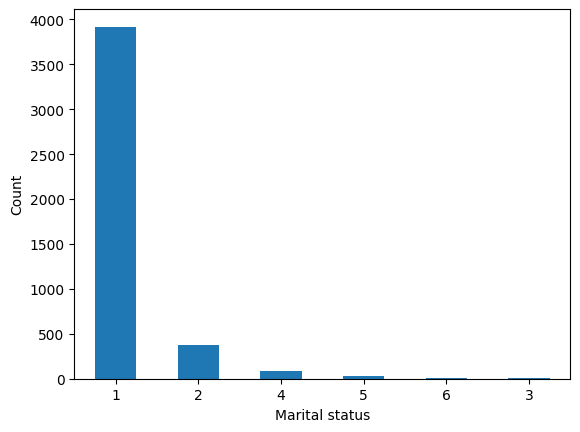

In [ ]:
dropoutdata['Marital status'].value_counts().plot(kind='bar', xlabel='Marital status', ylabel='Count', rot=0)

Application Mode (Categorical)

In [ ]:
dropoutdata['Application mode'].value_counts()

1     1721
17     869
39     780
43     308
44     213
7      139
18     124
42      76
51      59
16      38
53      35
15      30
5       16
10      10
2        3
26       1
27       1
57       1
Name: Application mode, dtype: int64

<Axes: xlabel='Application mode', ylabel='Count'>

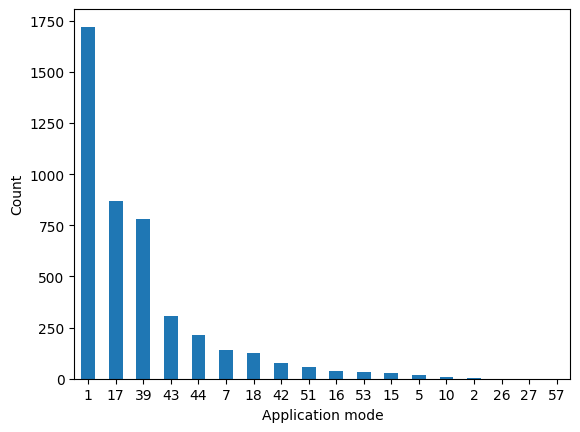

In [ ]:
dropoutdata['Application mode'].value_counts().plot(kind='bar', xlabel='Application mode', ylabel='Count', rot=0)

Application order (Categorical)

In [ ]:
dropoutdata['Application order'].value_counts()

1    3030
2     545
3     308
4     249
5     154
6     136
0       1
9       1
Name: Application order, dtype: int64

<Axes: xlabel='Application order', ylabel='Count'>

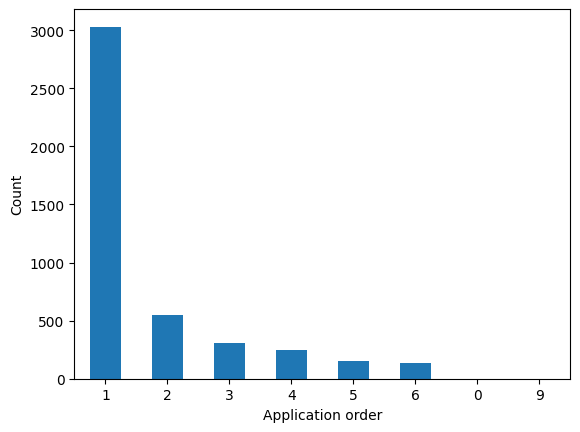

In [ ]:
dropoutdata['Application order'].value_counts().plot(kind='bar', xlabel='Application order', ylabel='Count', rot=0)

Course (Categorical)

In [ ]:
dropoutdata['Course'].value_counts()

9500    766
9147    380
9238    355
9085    337
9773    331
9670    268
9991    268
9254    252
9070    226
171     215
8014    215
9003    210
9853    192
9119    170
9130    141
9556     86
33       12
Name: Course, dtype: int64

<Axes: xlabel='Course', ylabel='Count'>

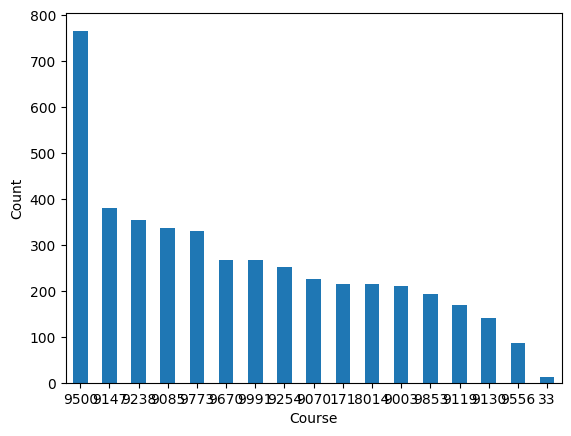

In [ ]:
dropoutdata['Course'].value_counts().plot(kind='bar', xlabel='Course', ylabel='Count', rot=0)

Daytime/evening attendance (Categorical)

In [ ]:
dropoutdata['Daytime/evening attendance'].value_counts()

1    3944
0     480
Name: Daytime/evening attendance, dtype: int64

<Axes: xlabel='Daytime/evening attendance', ylabel='Count'>

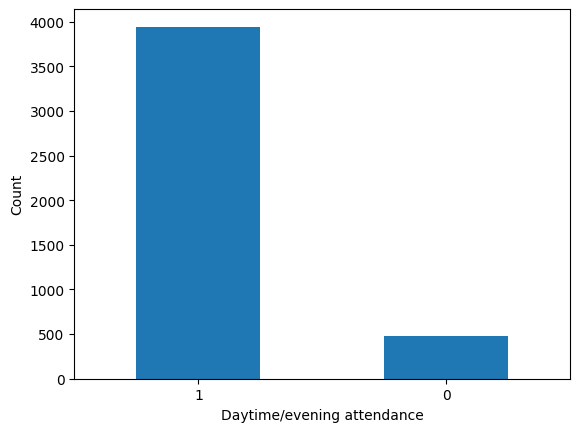

In [ ]:
dropoutdata['Daytime/evening attendance'].value_counts().plot(kind='bar', xlabel='Daytime/evening attendance', ylabel='Count', rot=0)

Previous qualification (Categorical)

In [ ]:
dropoutdata['Previous qualification'].value_counts()

1     3717
39     219
19     162
3      126
12      45
40      40
42      36
2       23
6       16
9       11
4        8
38       7
43       6
10       4
15       2
14       1
5        1
Name: Previous qualification, dtype: int64

<Axes: xlabel='Previous qualification', ylabel='Count'>

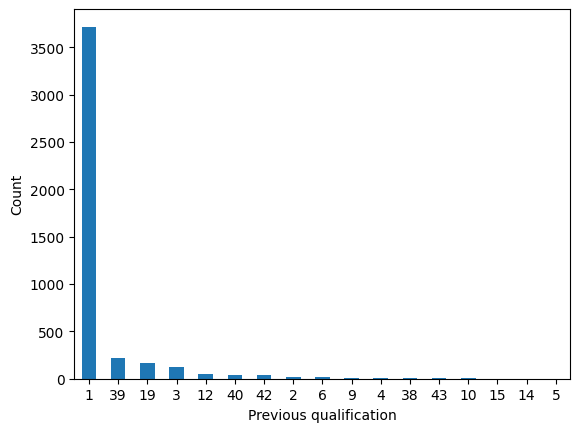

In [ ]:
dropoutdata['Previous qualification'].value_counts().plot(kind='bar', xlabel='Previous qualification', ylabel='Count', rot=0)

Previous qualification (grade) (Numerical)

In [ ]:
dropoutdata['Previous qualification (grade)'].describe()

count    4424.000000
mean      132.613314
std        13.188332
min        95.000000
25%       125.000000
50%       133.100000
75%       140.000000
max       190.000000
Name: Previous qualification (grade), dtype: float64

<Axes: >

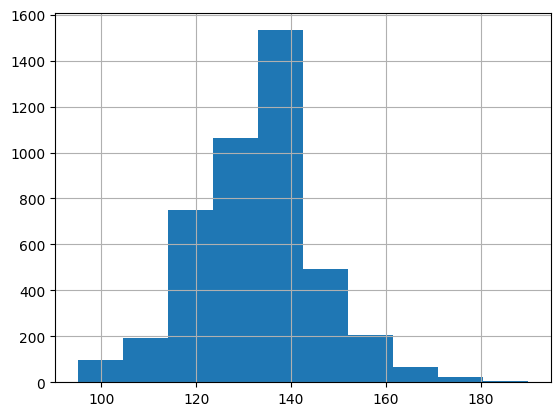

In [ ]:
dropoutdata['Previous qualification (grade)'].hist()

Nationality (Categorical)

In [ ]:
dropoutdata['Nacionality'].value_counts()

1      4314
41       38
26       14
6        13
22       13
24        5
11        3
103       3
100       3
105       2
101       2
62        2
25        2
2         2
21        2
32        1
17        1
14        1
13        1
108       1
109       1
Name: Nacionality, dtype: int64

<Axes: xlabel='Nationality', ylabel='Count'>

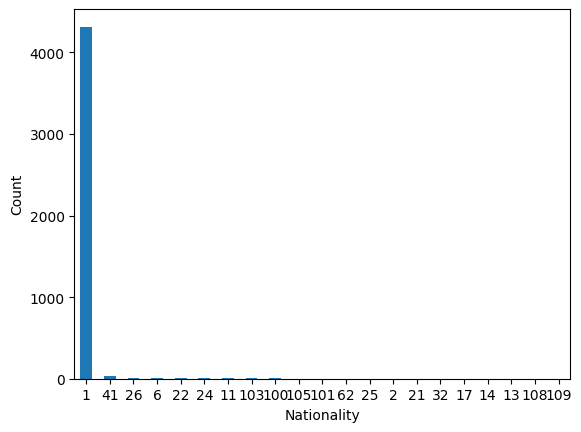

In [ ]:
dropoutdata['Nacionality'].value_counts().plot(kind='bar', xlabel='Nationality', ylabel='Count', rot=0)

Mother's qualification (Categorical)

In [ ]:
dropoutdata['Mother\'s qualification'].value_counts()

1     1069
37    1009
19     953
38     562
3      438
34     130
2       83
4       49
12      42
5       21
40       9
39       8
9        8
41       6
43       4
6        4
42       4
11       3
29       3
30       3
10       3
35       3
36       3
14       2
26       1
27       1
22       1
18       1
44       1
Name: Mother's qualification, dtype: int64

<Axes: xlabel="Mother's qualification", ylabel='Count'>

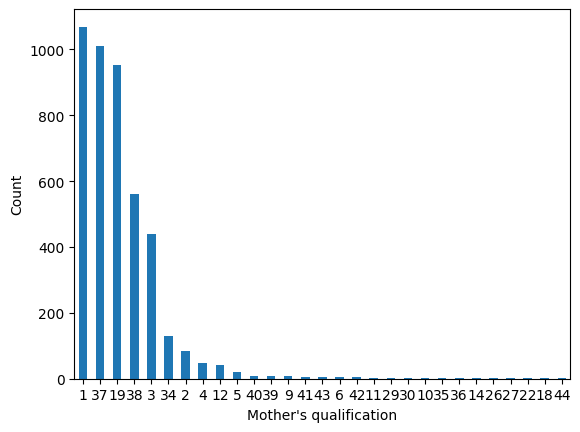

In [ ]:
dropoutdata['Mother\'s qualification'].value_counts().plot(kind='bar', xlabel='Mother\'s qualification', ylabel='Count', rot=0)

Father's qualification (Categorical)

In [ ]:
dropoutdata['Father\'s qualification'].value_counts()

37    1229
19     963
1      897
38     697
3      281
34     112
2       68
4       39
12      38
39      20
5       18
11      10
36       8
9        5
40       5
30       4
29       3
14       3
22       3
41       2
43       2
35       2
26       2
10       2
6        2
33       1
31       1
27       1
25       1
20       1
18       1
13       1
42       1
44       1
Name: Father's qualification, dtype: int64

<Axes: xlabel="Father's qualification", ylabel='Count'>

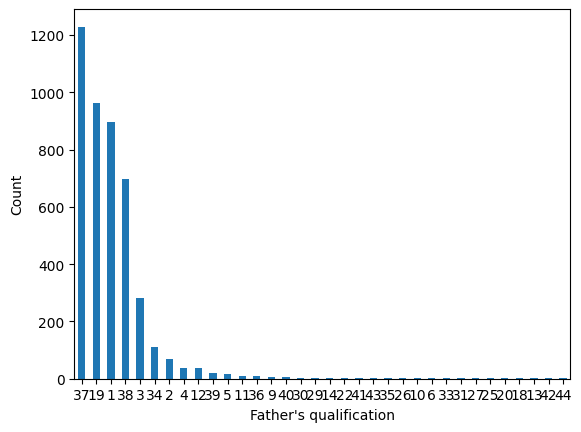

In [ ]:
dropoutdata['Father\'s qualification'].value_counts().plot(kind='bar', xlabel='Father\'s qualification', ylabel='Count', rot=0)

Mother's occupation (Categorical)

In [ ]:
dropoutdata['Mother\'s occupation'].value_counts()

9      1577
4       817
5       530
3       351
2       318
7       272
0       144
1       102
6        91
90       70
8        36
191      26
99       17
194      11
141       8
123       7
144       6
175       5
192       5
193       4
134       4
10        4
132       3
143       3
151       3
152       2
153       2
122       2
173       1
171       1
125       1
131       1
Name: Mother's occupation, dtype: int64

<Axes: xlabel="Mother's occupation", ylabel='Count'>

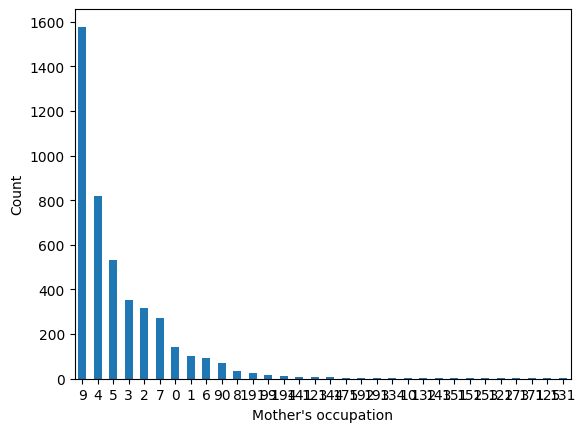

In [ ]:
dropoutdata['Mother\'s occupation'].value_counts().plot(kind='bar', xlabel='Mother\'s occupation', ylabel='Count', rot=0)

Father's Occupation (Categorical)

In [ ]:
dropoutdata['Father\'s occupation'].value_counts()

9      1031
7       663
5       512
4       384
3       383
8       314
10      263
6       241
2       195
1       134
0       127
90       65
99       19
193      15
144       8
171       8
192       6
163       5
103       4
175       4
152       3
135       3
181       3
183       3
123       3
102       2
182       2
194       2
151       2
122       2
172       2
112       2
174       1
132       1
161       1
154       1
153       1
143       1
141       1
134       1
131       1
124       1
121       1
114       1
101       1
195       1
Name: Father's occupation, dtype: int64

<Axes: xlabel="Father's occupation", ylabel='Count'>

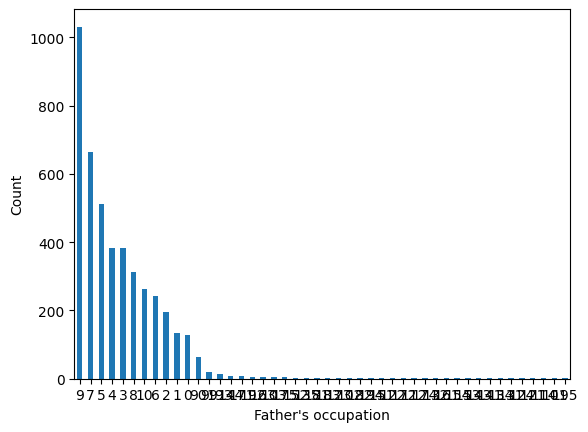

In [ ]:
dropoutdata['Father\'s occupation'].value_counts().plot(kind='bar', xlabel='Father\'s occupation', ylabel='Count', rot=0)

Admission grade (Numerical)

In [ ]:
dropoutdata['Admission grade'].describe()

count    4424.000000
mean      126.978119
std        14.482001
min        95.000000
25%       117.900000
50%       126.100000
75%       134.800000
max       190.000000
Name: Admission grade, dtype: float64

<Axes: >

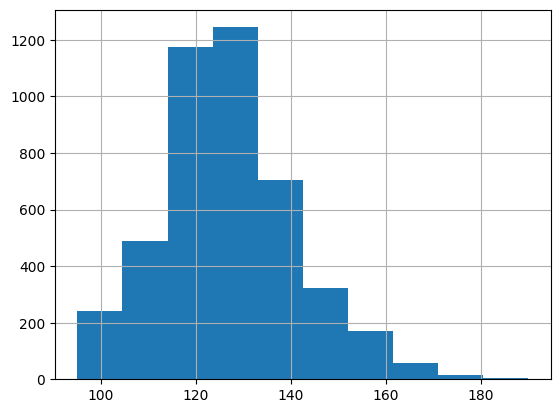

In [ ]:
dropoutdata['Admission grade'].hist()

Displaced (Categorical)

In [ ]:
dropoutdata['Displaced'].value_counts()

1    2426
0    1998
Name: Displaced, dtype: int64

<Axes: xlabel='Displaced', ylabel='Count'>

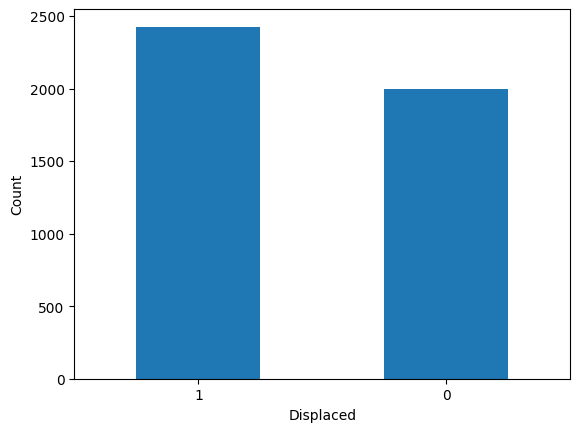

In [ ]:
dropoutdata['Displaced'].value_counts().plot(kind='bar', xlabel='Displaced', ylabel='Count', rot=0)

Educational special needs (Categorical)

In [ ]:
dropoutdata['Educational special needs'].value_counts()

0    4373
1      51
Name: Educational special needs, dtype: int64

<Axes: xlabel='Educational special needs', ylabel='Count'>

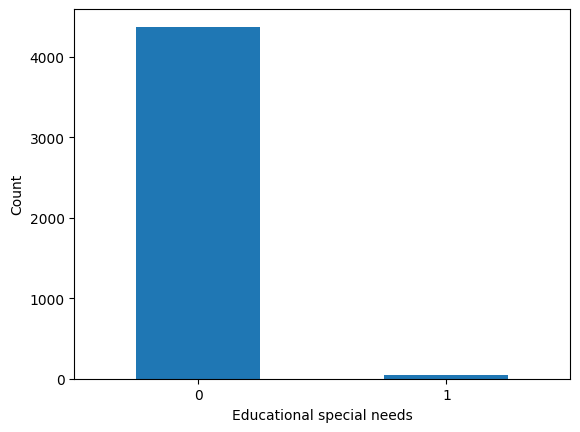

In [ ]:
dropoutdata['Educational special needs'].value_counts().plot(kind='bar', xlabel='Educational special needs', ylabel='Count', rot=0)

Debtor (Categorical)

In [ ]:
dropoutdata['Debtor'].value_counts()

0    3921
1     503
Name: Debtor, dtype: int64

<Axes: xlabel='Debtor', ylabel='Count'>

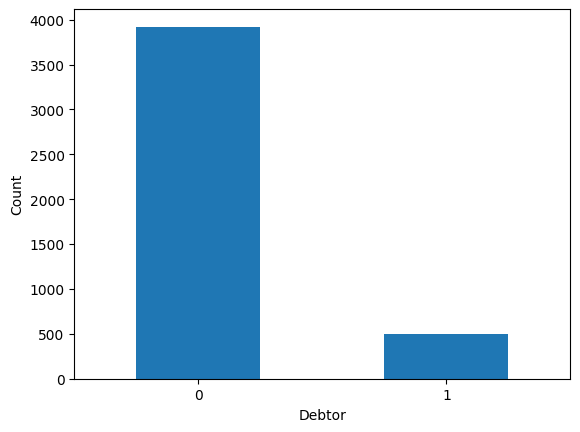

In [ ]:
dropoutdata['Debtor'].value_counts().plot(kind='bar', xlabel='Debtor', ylabel='Count', rot=0)

Tuition fees up to date (Categorical)

In [ ]:
dropoutdata['Tuition fees up to date'].value_counts()

1    3896
0     528
Name: Tuition fees up to date, dtype: int64

<Axes: xlabel='Tuition fees up to date', ylabel='Count'>

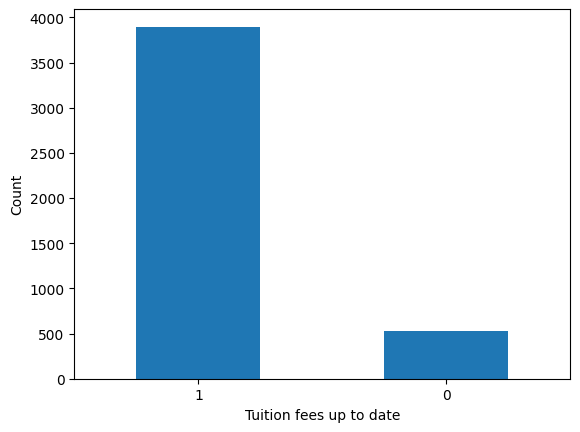

In [ ]:
dropoutdata['Tuition fees up to date'].value_counts().plot(kind='bar', xlabel='Tuition fees up to date', ylabel='Count', rot=0)

Gender (Categorical)

In [ ]:
dropoutdata['Gender'].value_counts()

0    2868
1    1556
Name: Gender, dtype: int64

<Axes: xlabel='Gender', ylabel='Count'>

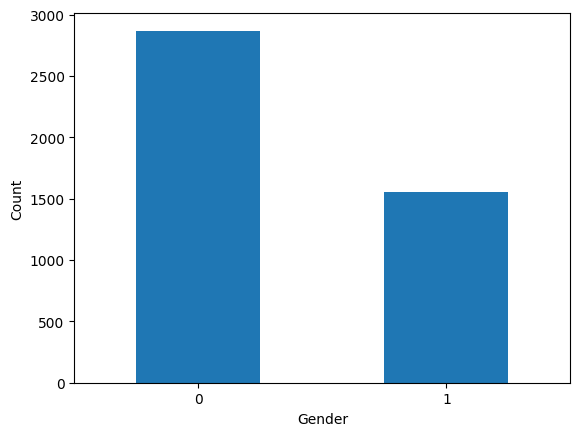

In [ ]:
dropoutdata['Gender'].value_counts().plot(kind='bar', xlabel='Gender', ylabel='Count', rot=0)

Scholarship Holder (Categorical)

In [ ]:
dropoutdata['Scholarship holder'].value_counts()

0    3325
1    1099
Name: Scholarship holder, dtype: int64

<Axes: xlabel='Scholarship holder', ylabel='Count'>

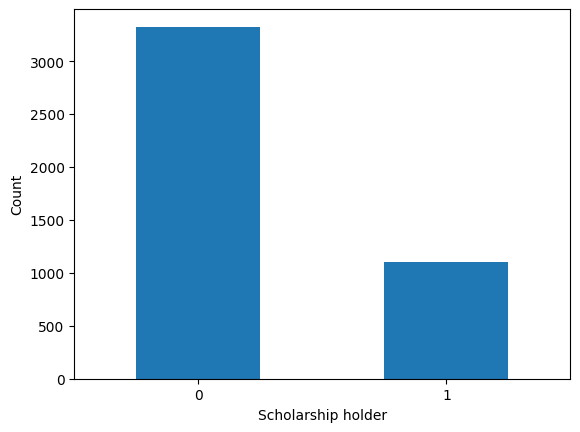

In [ ]:
dropoutdata['Scholarship holder'].value_counts().plot(kind='bar', xlabel='Scholarship holder', ylabel='Count', rot=0)

Age at enrollment (Numerical)

In [ ]:
dropoutdata['Age at enrollment'].describe()

count    4424.000000
mean       23.265145
std         7.587816
min        17.000000
25%        19.000000
50%        20.000000
75%        25.000000
max        70.000000
Name: Age at enrollment, dtype: float64

<Axes: >

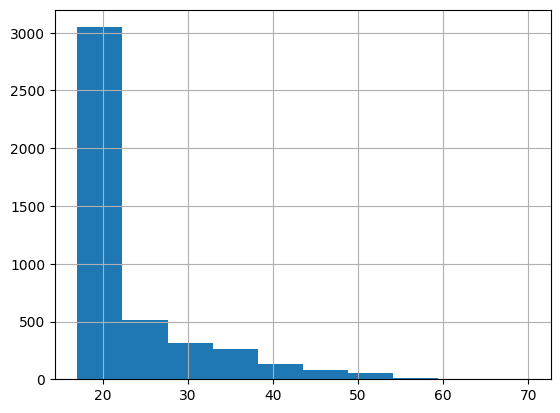

In [ ]:
dropoutdata['Age at enrollment'].hist()

International

In [ ]:
dropoutdata['Age at enrollment'].describe()

count    4424.000000
mean       23.265145
std         7.587816
min        17.000000
25%        19.000000
50%        20.000000
75%        25.000000
max        70.000000
Name: Age at enrollment, dtype: float64

<Axes: >

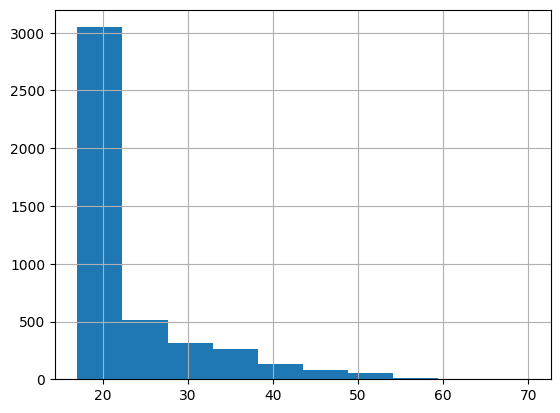

In [ ]:
dropoutdata['Age at enrollment'].hist()

In [ ]:
Curricular units 1st sem (credited) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (credited)'].describe()

count    4424.000000
mean        0.709991
std         2.360507
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        20.000000
Name: Curricular units 1st sem (credited), dtype: float64

<Axes: >

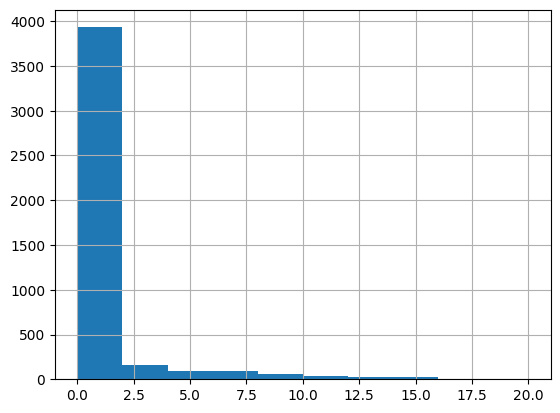

In [ ]:
dropoutdata['Curricular units 1st sem (credited)'].hist()

Curricular units 1st sem (enrolled) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (enrolled)'].describe()

count    4424.000000
mean        6.270570
std         2.480178
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        26.000000
Name: Curricular units 1st sem (enrolled), dtype: float64

<Axes: >

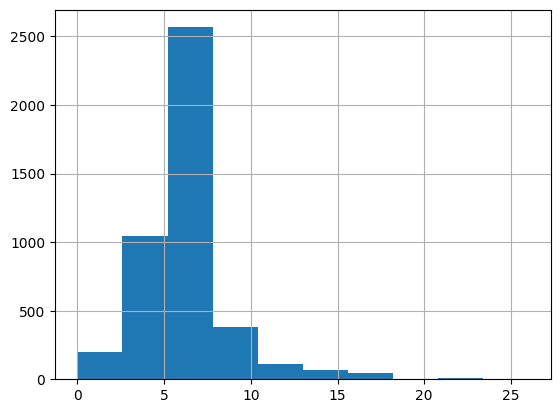

In [ ]:
dropoutdata['Curricular units 1st sem (enrolled)'].hist()

Curricular units 1st sem (evaluations) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (evaluations)'].describe()

count    4424.000000
mean        8.298031
std         4.176376
min         0.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        45.000000
Name: Curricular units 1st sem (evaluations), dtype: float64

<Axes: >

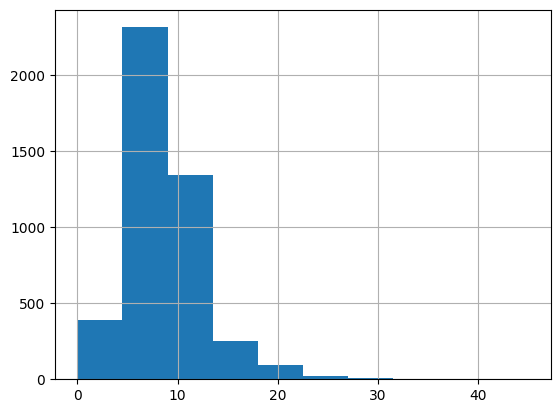

In [ ]:
dropoutdata['Curricular units 1st sem (evaluations)'].hist()

Curricular units 1st sem (approved) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (approved)'].describe()

count    4424.000000
mean        4.705254
std         3.085708
min         0.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        26.000000
Name: Curricular units 1st sem (approved), dtype: float64

<Axes: >

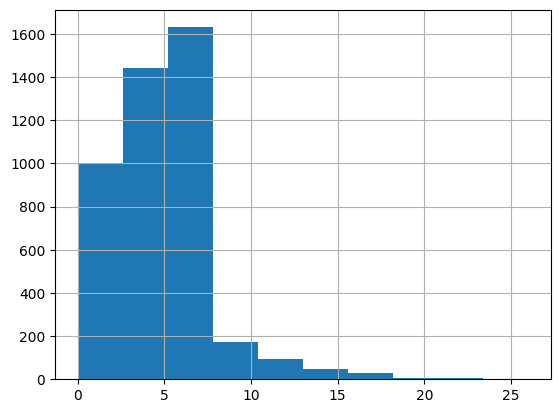

In [ ]:
dropoutdata['Curricular units 1st sem (approved)'].hist()

Curricular units 1st sem (grade) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (grade)'].describe()

count    4424.000000
mean       10.640822
std         4.843663
min         0.000000
25%        11.000000
50%        12.285714
75%        13.400000
max        18.875000
Name: Curricular units 1st sem (grade), dtype: float64

<Axes: >

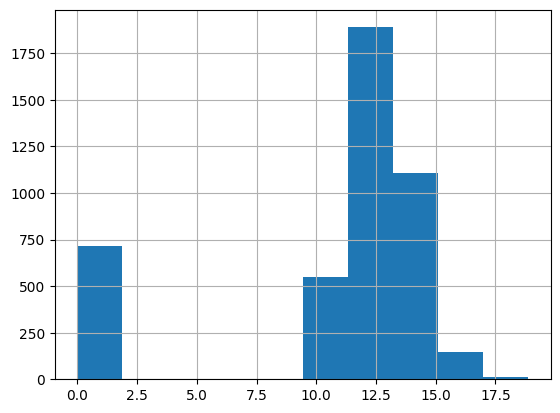

In [ ]:
dropoutdata['Curricular units 1st sem (grade)'].hist()

Curricular units 1st sem (without evaluations) (Numerical)

In [ ]:
dropoutdata['Curricular units 1st sem (without evaluations)'].describe()

count    4424.000000
mean        0.137658
std         0.690880
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: Curricular units 1st sem (without evaluations), dtype: float64

<Axes: >

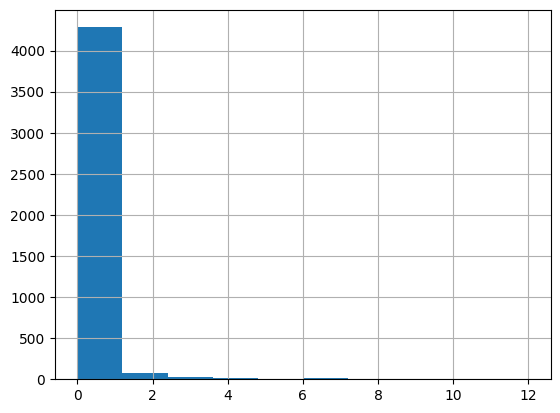

In [ ]:
dropoutdata['Curricular units 1st sem (without evaluations)'].hist()

Curricular units 2nd sem (credited) (Numerical)

In [ ]:
dropoutdata['Curricular units 2nd sem (credited)'].describe()

count    4424.000000
mean        0.541817
std         1.918546
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        19.000000
Name: Curricular units 2nd sem (credited), dtype: float64

<Axes: >

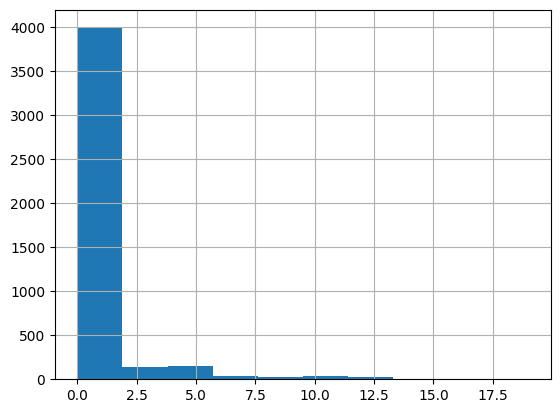

In [ ]:
dropoutdata['Curricular units 2nd sem (credited)'].hist()

Curricular units 2nd sem (enrolled) (Numerical)

In [ ]:
dropoutdata['Curricular units 2nd sem (enrolled)'].describe()

count    4424.000000
mean        6.232143
std         2.195951
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        23.000000
Name: Curricular units 2nd sem (enrolled), dtype: float64

<Axes: >

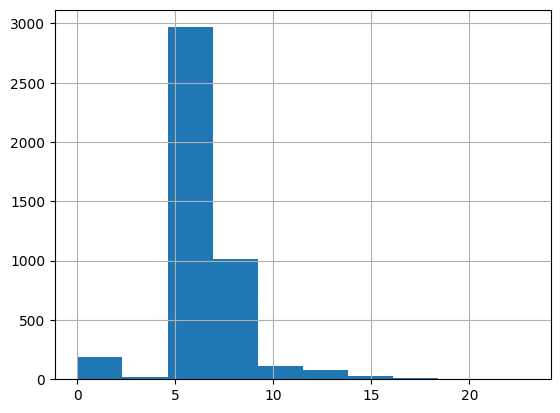

In [ ]:
dropoutdata['Curricular units 2nd sem (enrolled)'].hist()

Curricular units 2nd sem (evaluations) (Numerical)

In [ ]:
dropoutdata['Curricular units 2nd sem (evaluations)'].describe()

count    4424.000000
mean        8.063291
std         3.947951
min         0.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        33.000000
Name: Curricular units 2nd sem (evaluations), dtype: float64

<Axes: >

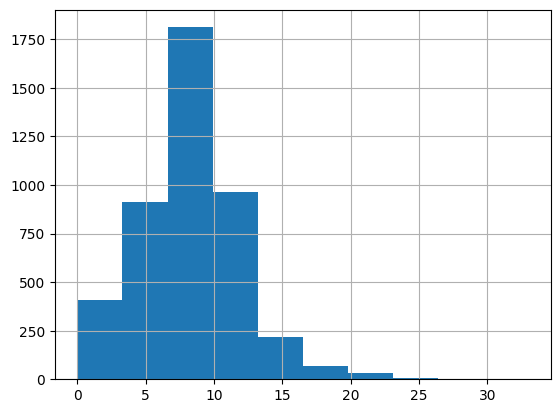

In [ ]:
dropoutdata['Curricular units 2nd sem (evaluations)'].hist()

Curricular units 2nd sem (approved)

In [ ]:
dropoutdata['Curricular units 2nd sem (approved)'].describe()

count    4424.000000
mean        4.435805
std         3.014764
min         0.000000
25%         2.000000
50%         5.000000
75%         6.000000
max        20.000000
Name: Curricular units 2nd sem (approved), dtype: float64

<Axes: >

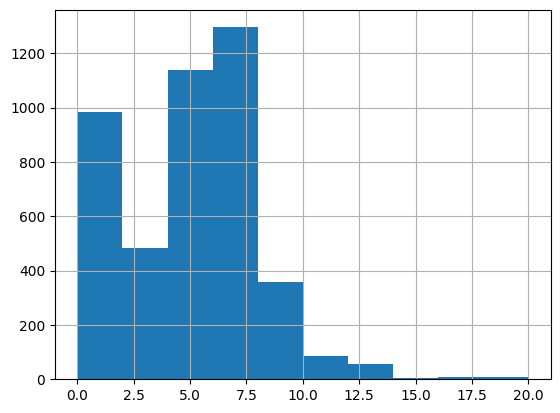

In [ ]:
dropoutdata['Curricular units 2nd sem (approved)'].hist()

Curricular units 2nd sem (grade) (Numerical)

In [ ]:
dropoutdata['Curricular units 2nd sem (grade)'].describe()

count    4424.000000
mean       10.230206
std         5.210808
min         0.000000
25%        10.750000
50%        12.200000
75%        13.333333
max        18.571429
Name: Curricular units 2nd sem (grade), dtype: float64

<Axes: >

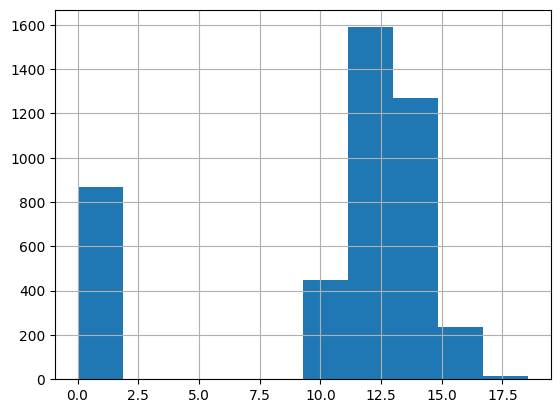

In [ ]:
dropoutdata['Curricular units 2nd sem (grade)'].hist()

Curricular units 2nd sem (without evaluations) (Numerical)

In [ ]:
dropoutdata['Curricular units 2nd sem (without evaluations)'].describe()

count    4424.000000
mean        0.150943
std         0.753584
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: Curricular units 2nd sem (without evaluations), dtype: float64

<Axes: >

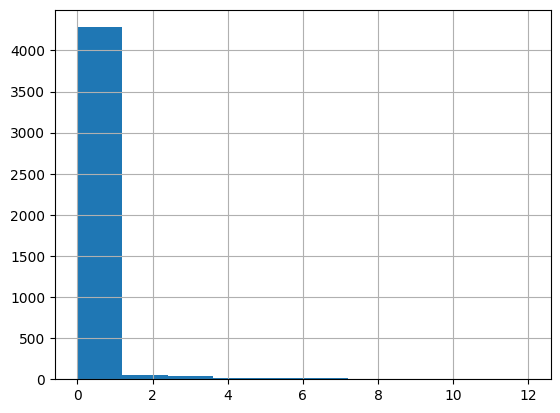

In [ ]:
dropoutdata['Curricular units 2nd sem (without evaluations)'].hist()

Unemployment rate (Numerical)

In [ ]:
dropoutdata['Unemployment rate'].describe()

count    4424.000000
mean       11.566139
std         2.663850
min         7.600000
25%         9.400000
50%        11.100000
75%        13.900000
max        16.200000
Name: Unemployment rate, dtype: float64

<Axes: >

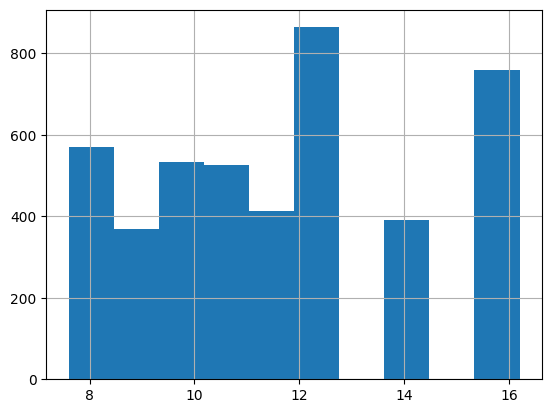

In [ ]:
dropoutdata['Unemployment rate'].hist()

Inflation rate (Numerical)

In [ ]:
dropoutdata['Inflation rate'].describe()

count    4424.000000
mean        1.228029
std         1.382711
min        -0.800000
25%         0.300000
50%         1.400000
75%         2.600000
max         3.700000
Name: Inflation rate, dtype: float64

<Axes: >

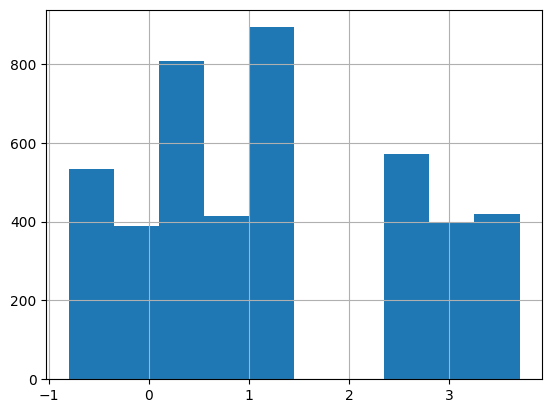

In [ ]:
dropoutdata['Inflation rate'].hist()

GDP (Numerical)

In [ ]:
dropoutdata['GDP'].describe()

count    4424.000000
mean        0.001969
std         2.269935
min        -4.060000
25%        -1.700000
50%         0.320000
75%         1.790000
max         3.510000
Name: GDP, dtype: float64

<Axes: >

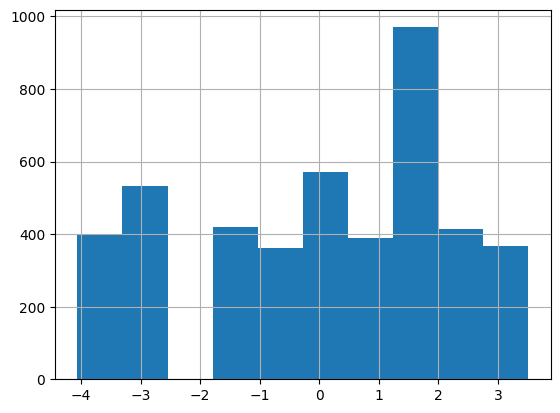

In [ ]:
dropoutdata['GDP'].hist()

Target (Categorical)

In [ ]:
dropoutdata['Target'].value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

<Axes: xlabel='Target', ylabel='Count'>

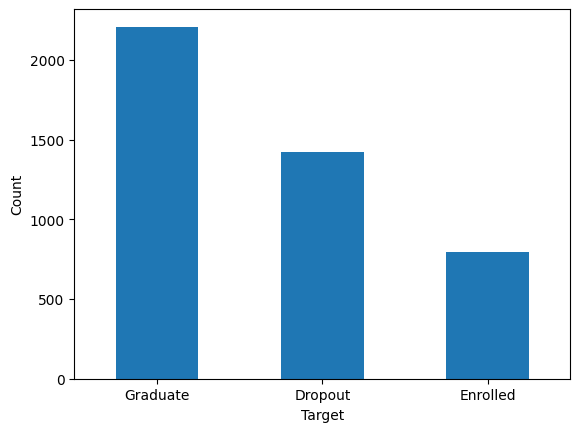

In [ ]:
dropoutdata['Target'].value_counts().plot(kind='bar', xlabel='Target', ylabel='Count', rot=0)

# Exploratory Data Analysis
The data cleaning process assisted with the exploratory data analysis, as it provides some insight into the shape and structure of the data.

<Axes: xlabel='Target', ylabel='Count'>

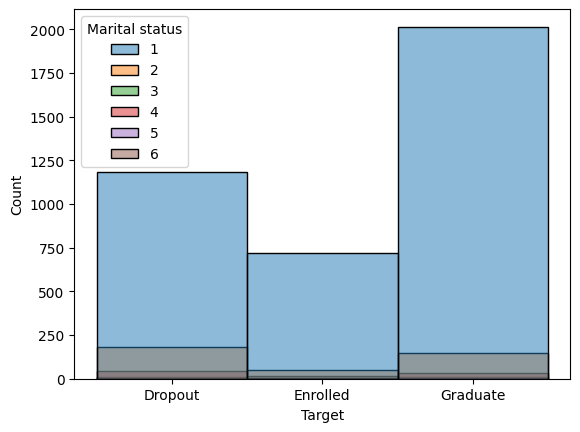

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Marital status', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

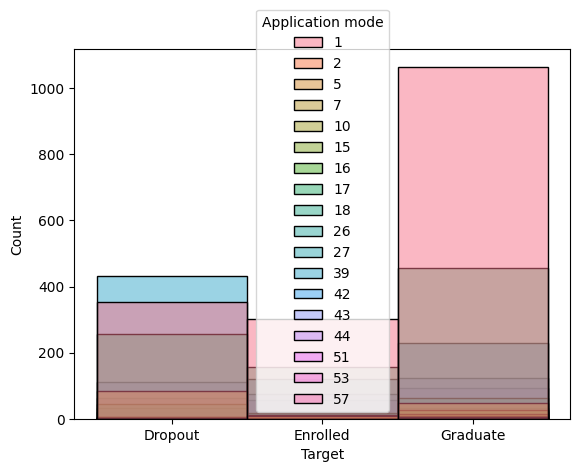

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Application mode', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

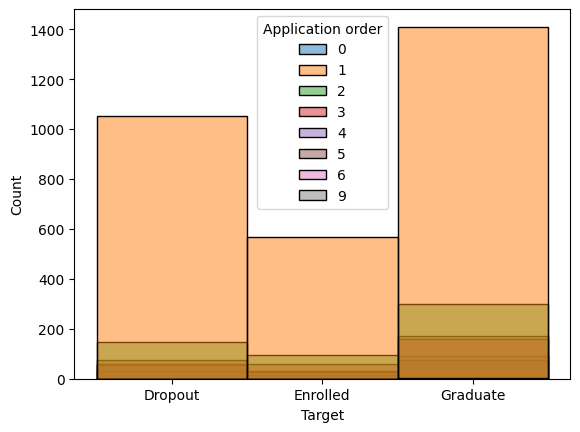

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Application order', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

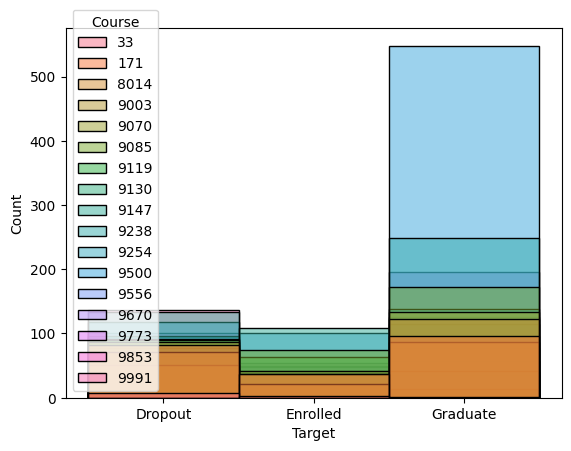

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Course', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

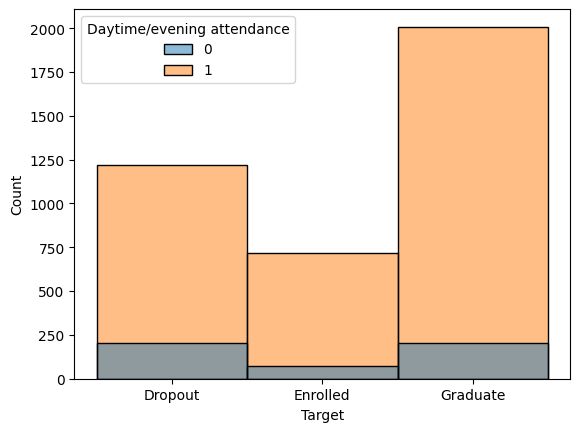

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Daytime/evening attendance', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

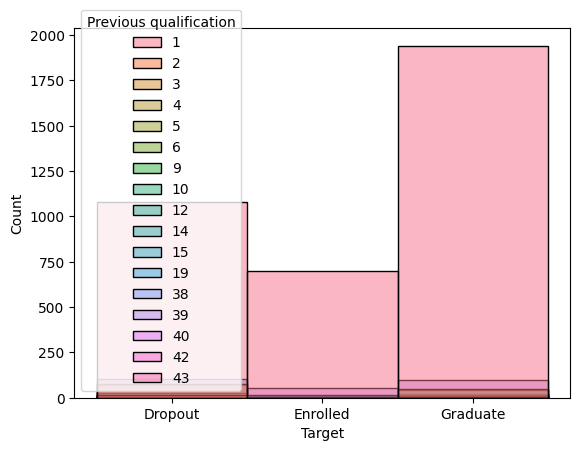

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Previous qualification', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

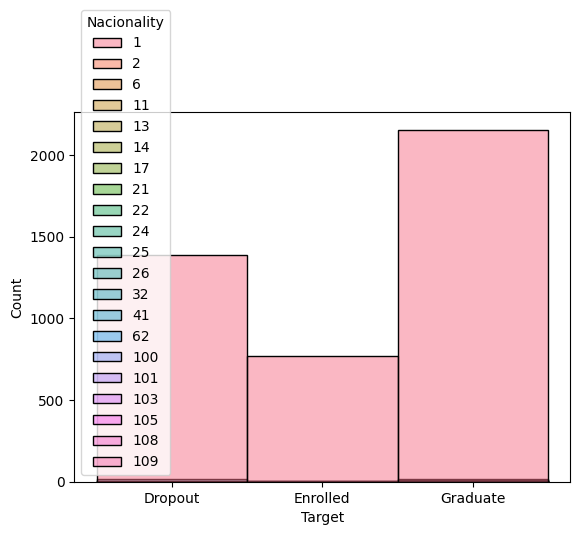

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Nacionality', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

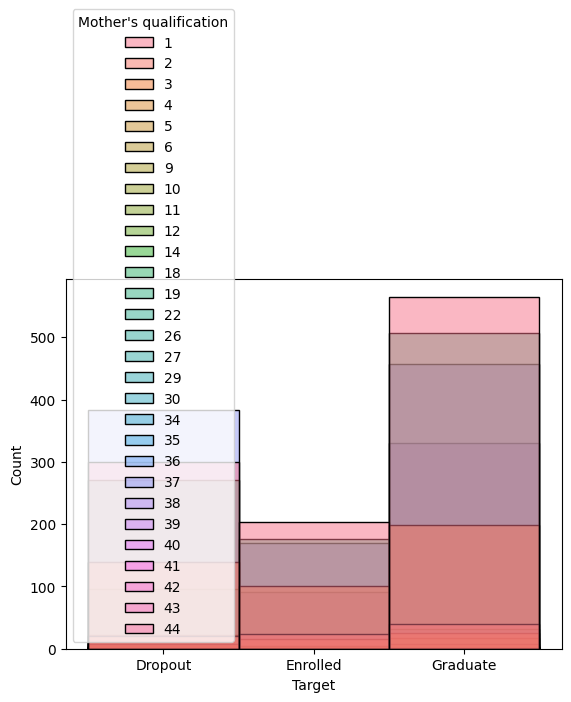

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Mother\'s qualification', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

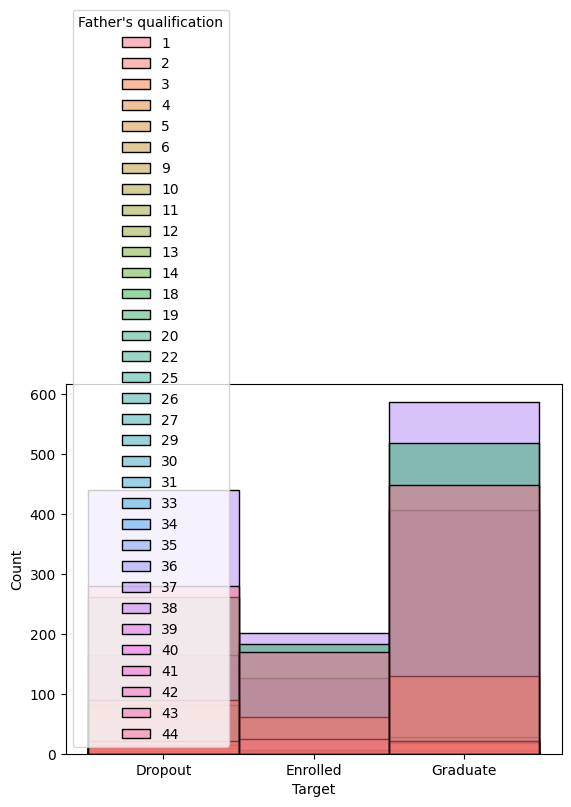

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Father\'s qualification', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

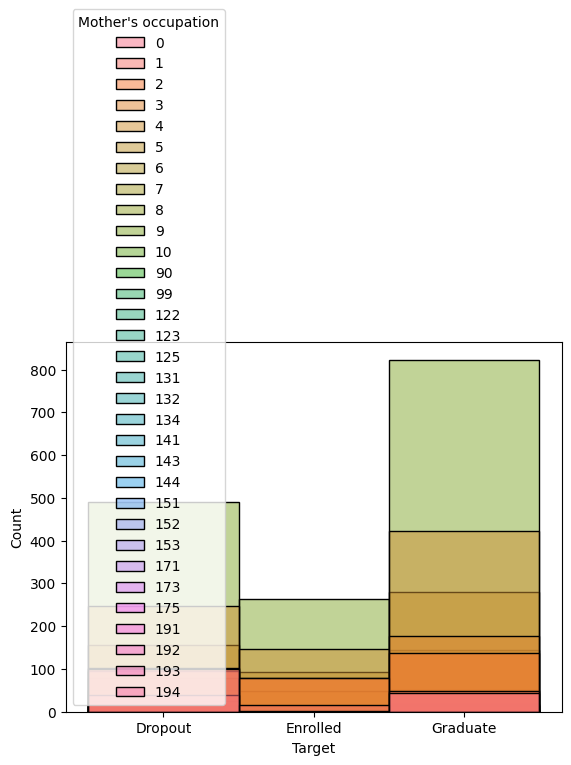

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Mother\'s occupation', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

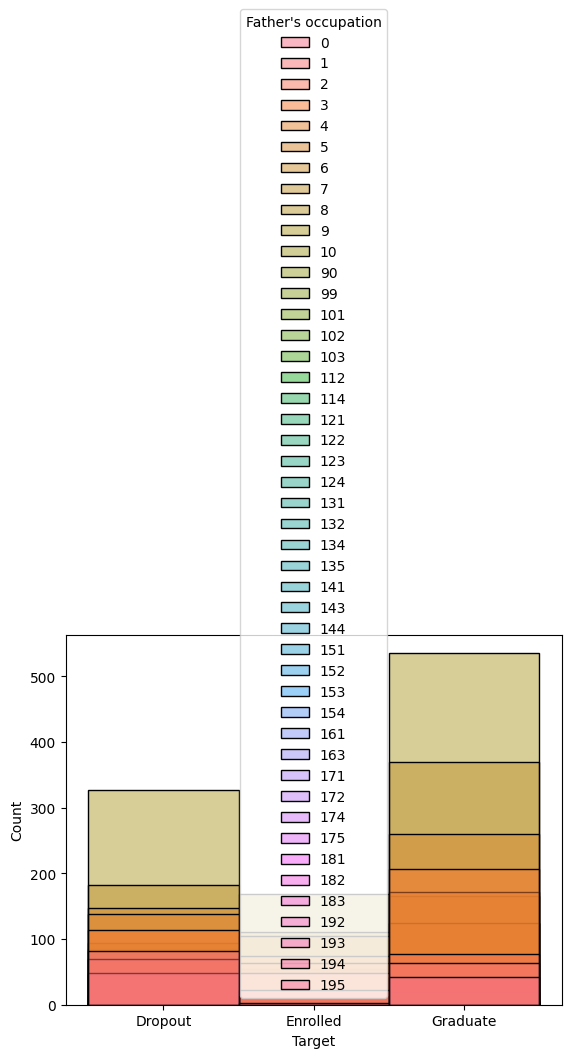

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Father\'s occupation', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

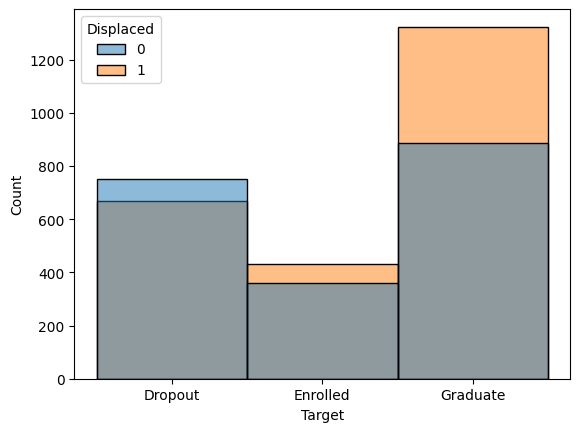

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Displaced', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

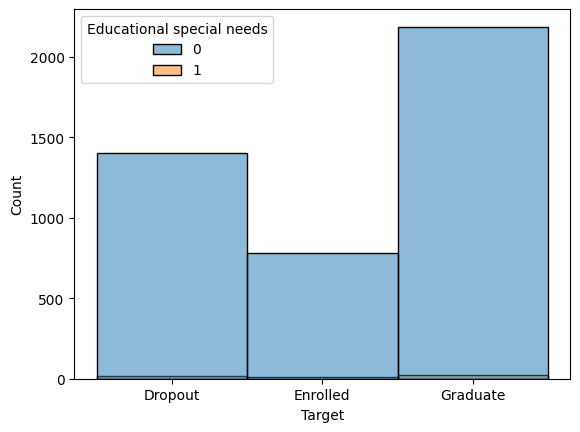

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Educational special needs', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

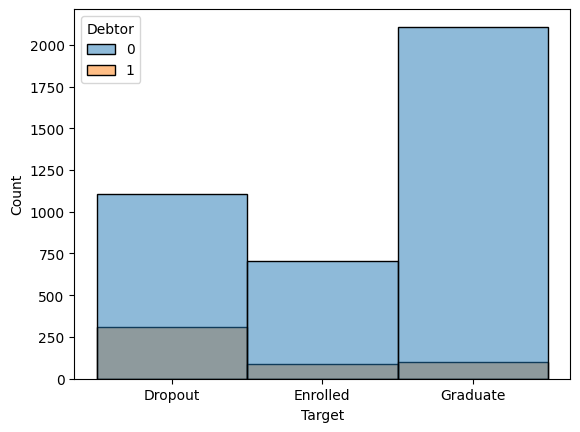

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Debtor', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

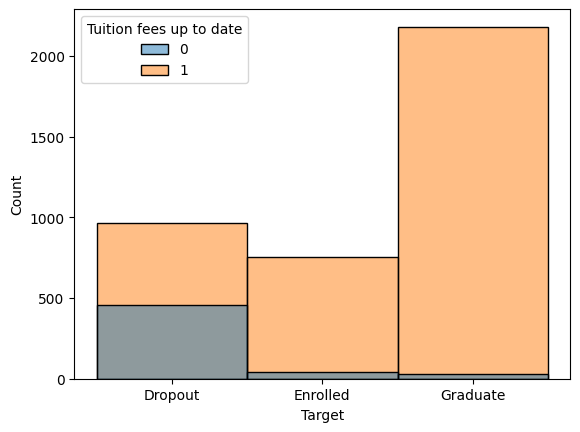

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Tuition fees up to date', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

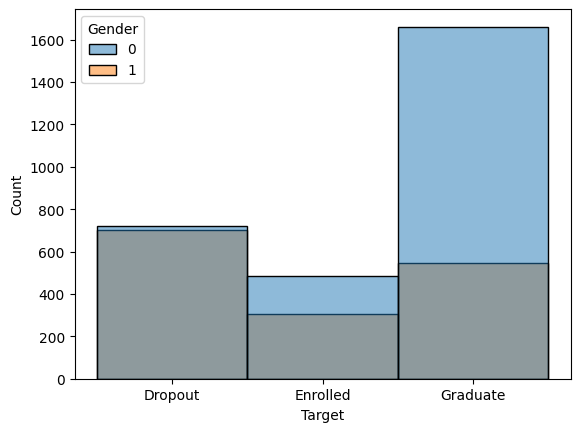

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Gender', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

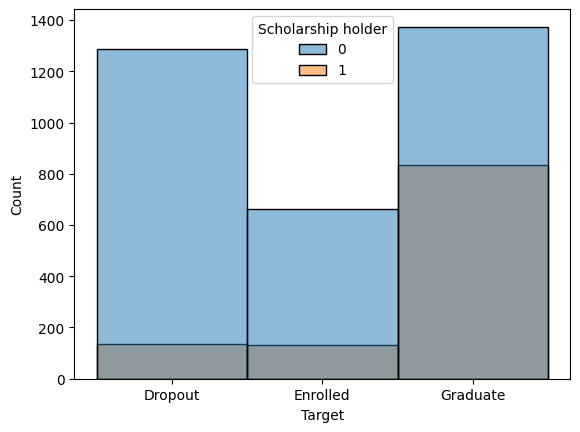

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='Scholarship holder', binwidth=1)

<Axes: xlabel='Target', ylabel='Count'>

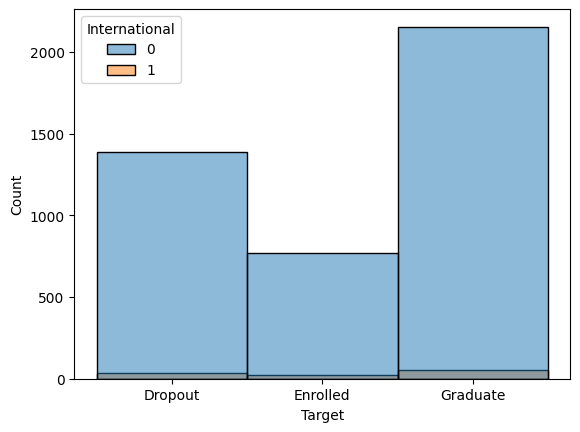

In [ ]:
sns.histplot(data=dropoutdata, x='Target', hue='International', binwidth=1)

<Axes: xlabel='Target', ylabel='Previous qualification (grade)'>

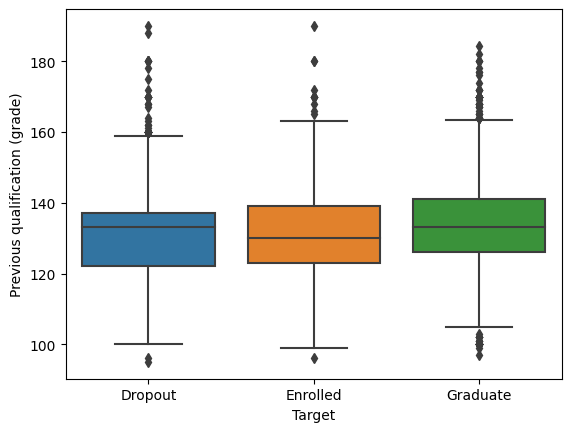

In [ ]:
sns.boxplot(x ='Target', y ='Previous qualification (grade)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Admission grade'>

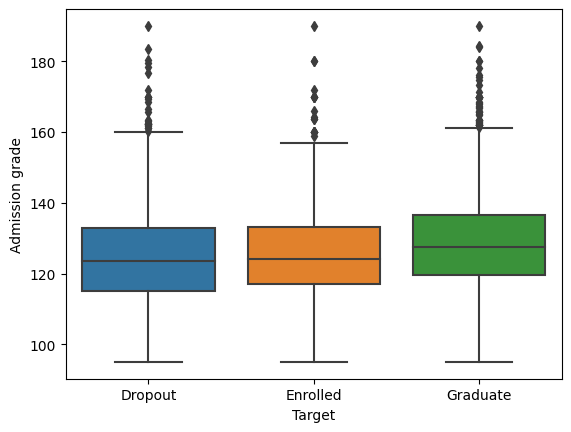

In [ ]:
sns.boxplot(x ='Target', y ='Admission grade', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Age at enrollment'>

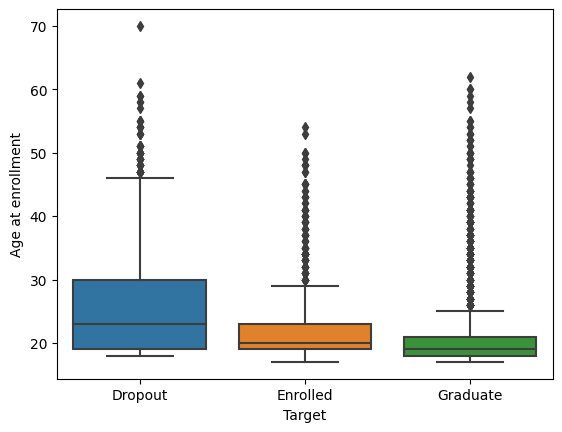

In [ ]:
sns.boxplot(x ='Target', y ='Age at enrollment', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (credited)'>

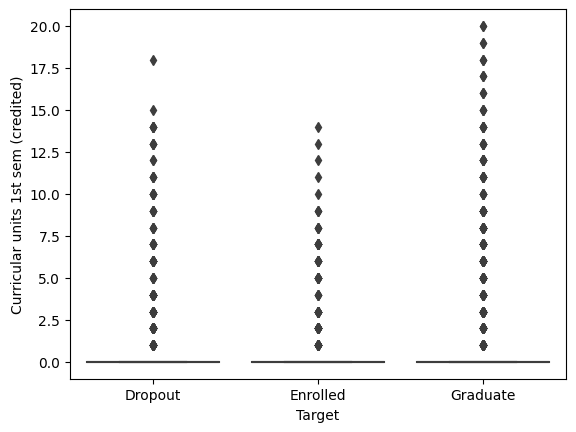

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (credited)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (enrolled)'>

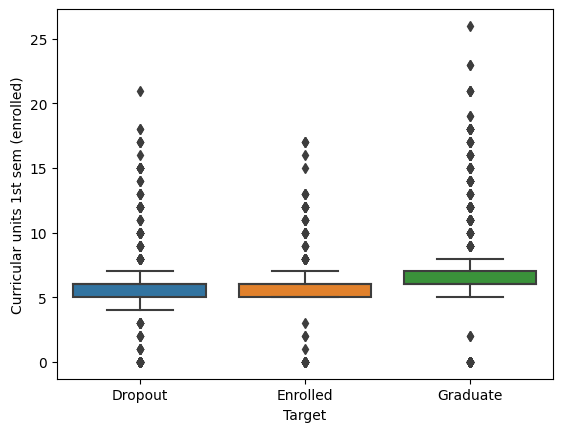

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (enrolled)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (evaluations)'>

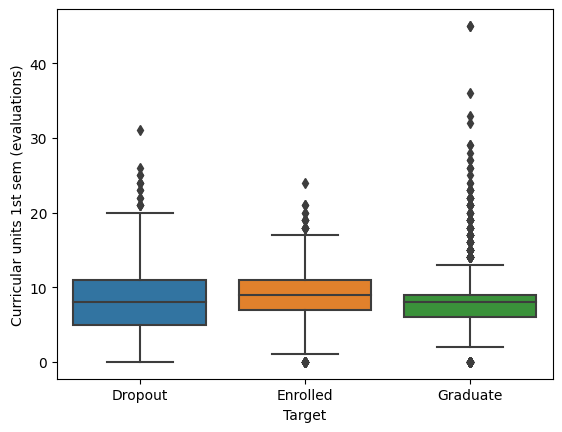

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (evaluations)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (approved)'>

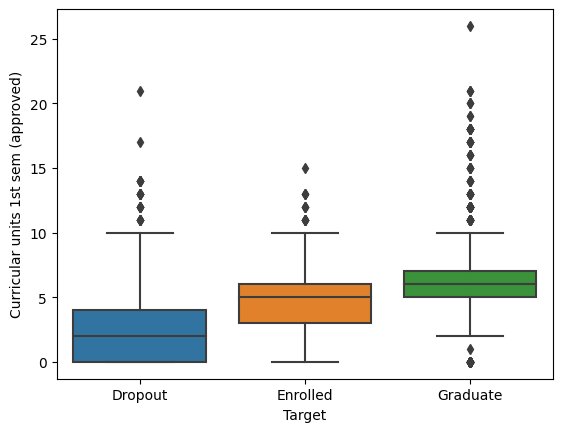

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (approved)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (grade)'>

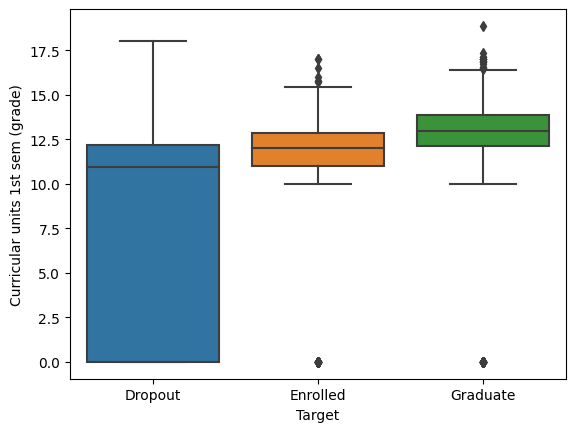

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (grade)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 1st sem (without evaluations)'>

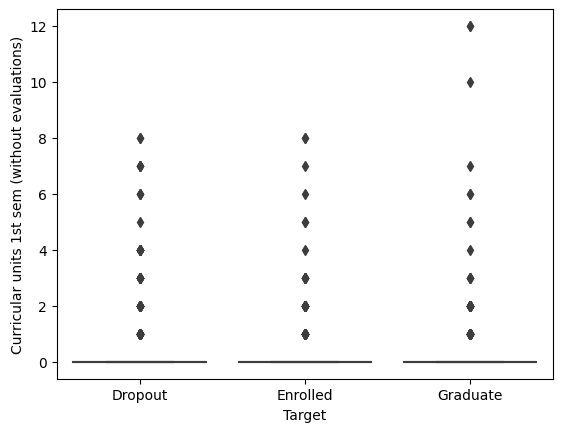

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 1st sem (without evaluations)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (credited)'>

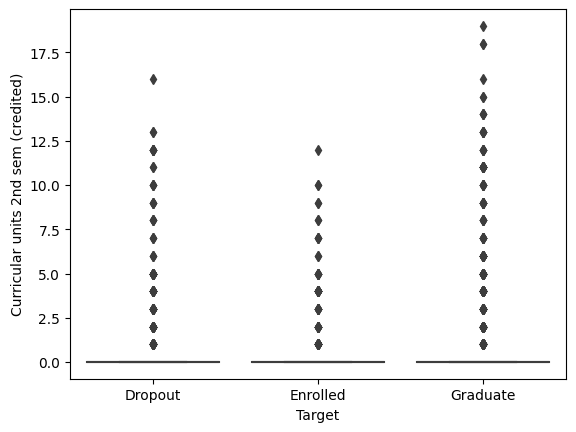

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (credited)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (enrolled)'>

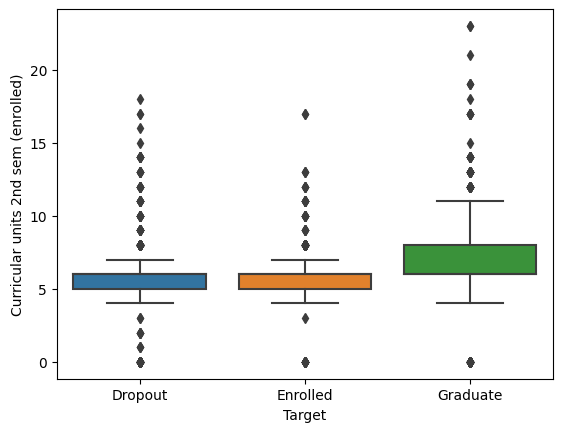

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (enrolled)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (evaluations)'>

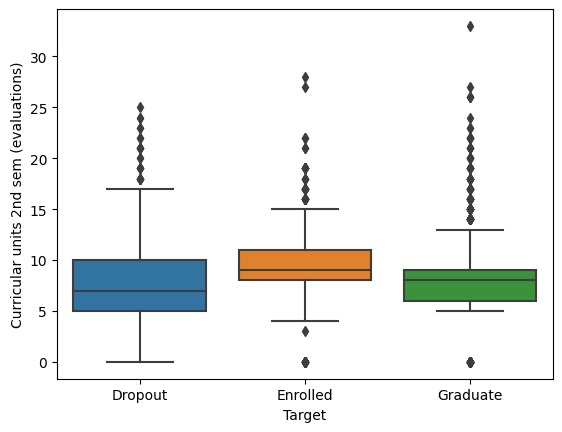

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (evaluations)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (approved)'>

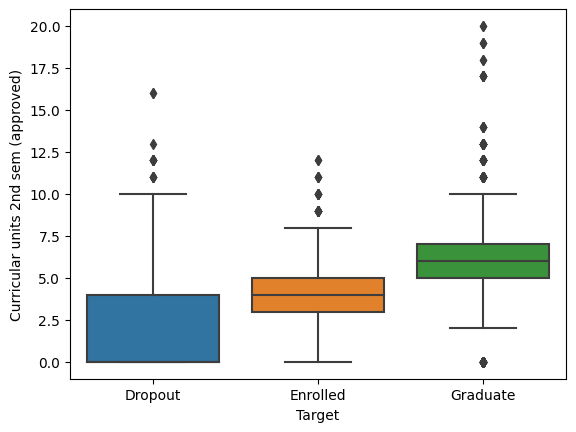

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (approved)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (grade)'>

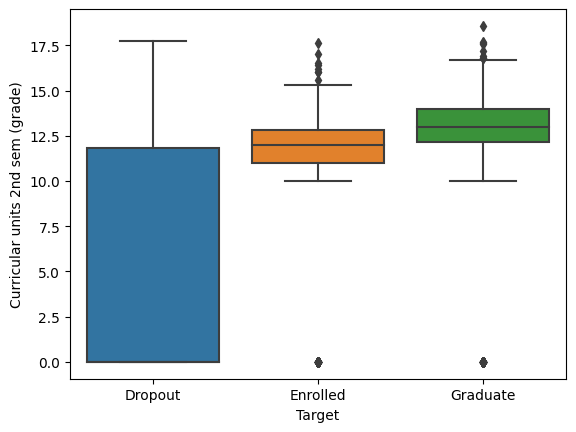

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (grade)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (without evaluations)'>

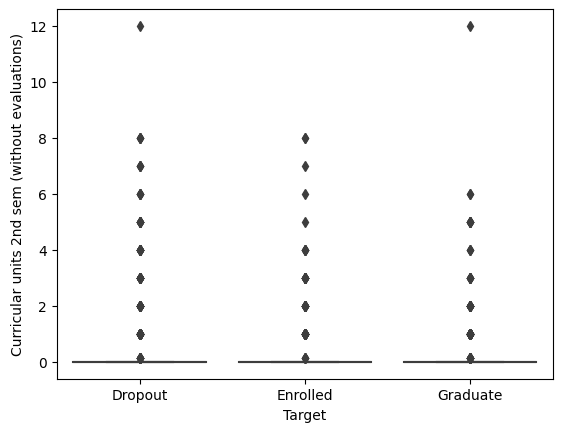

In [ ]:
sns.boxplot(x ='Target', y ='Curricular units 2nd sem (without evaluations)', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Unemployment rate'>

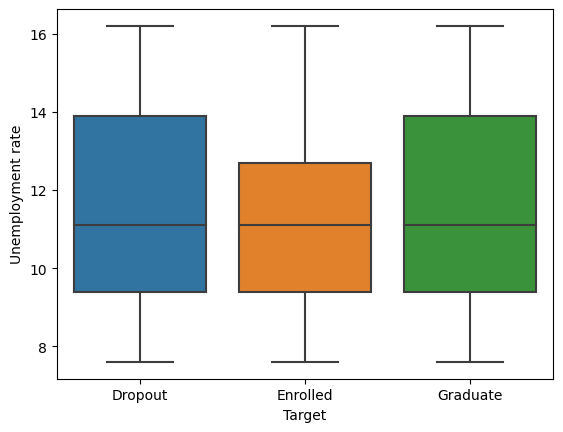

In [ ]:
sns.boxplot(x ='Target', y ='Unemployment rate', data=dropoutdata)

<Axes: xlabel='Target', ylabel='Inflation rate'>

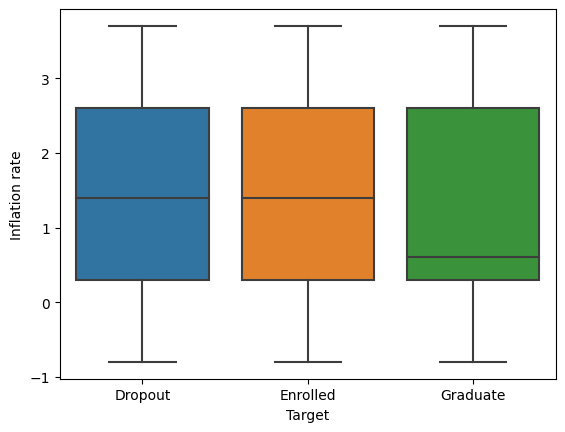

In [ ]:
sns.boxplot(x ='Target', y ='Inflation rate', data=dropoutdata)

<Axes: xlabel='Target', ylabel='GDP'>

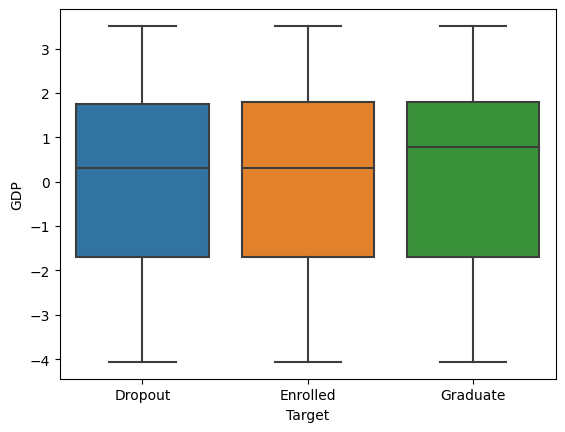

In [ ]:
sns.boxplot(x ='Target', y ='GDP', data=dropoutdata)

# Follow Up Exploratory Data Analysis
The "eyeballing" of the data reveals the following as potentially helpful for distinguishing between dropouts, enrolled students, and graduates:

**Categorical**
* Application Mode
* Course
* Mother's qualification
* Father's qualification
* Tuition fees up to date

**Numerical**
* Curricular units 1st sem (approved)
* Curricular units 1st sem (grade)
* Curricular units 2nd sem (approved)
* Curricular units 2nd sem (grade)
* Inflation rate


Each of these will be investigated further with contingency tables, both raw and normalised.

In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Application mode'], margins=True)

Application mode,1,2,5,7,10,15,16,17,18,26,27,39,42,43,44,51,53,57,All
Target,,,,,,,,,,,,,,,,,,,
Dropout,353,2,2,85,3,5,5,255,45,1,1,433,33,111,63,20,4,0,1421
Enrolled,303,0,8,7,0,10,8,158,16,0,0,119,11,75,56,13,10,0,794
Graduate,1065,1,6,47,7,15,25,456,63,0,0,228,32,122,94,26,21,1,2209
All,1721,3,16,139,10,30,38,869,124,1,1,780,76,308,213,59,35,1,4424


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Application mode'], normalize="columns", margins=True)

Application mode,1,2,5,7,10,15,16,17,18,26,27,39,42,43,44,51,53,57,All
Target,,,,,,,,,,,,,,,,,,,
Dropout,0.205113,0.666667,0.125,0.611511,0.3,0.166667,0.131579,0.293441,0.362903,1.0,1.0,0.555128,0.434211,0.360390,0.295775,0.338983,0.114286,0.0,0.321203
Enrolled,0.176060,0.000000,0.500,0.050360,0.0,0.333333,0.210526,0.181818,0.129032,0.0,0.0,0.152564,0.144737,0.243506,0.262911,0.220339,0.285714,0.0,0.179476
Graduate,0.618826,0.333333,0.375,0.338129,0.7,0.500000,0.657895,0.524741,0.508065,0.0,0.0,0.292308,0.421053,0.396104,0.441315,0.440678,0.600000,1.0,0.499322


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Course'], margins=True)

Course,33,171,8014,9003,9070,9085,9119,9130,9147,9238,9254,9500,9556,9670,9773,9853,9991,All
Target,,,,,,,,,,,,,,,,,,
Dropout,8,82,71,86,51,90,92,78,134,65,96,118,33,95,101,85,136,1421
Enrolled,3,37,21,37,42,75,64,21,108,42,41,100,17,48,34,50,54,794
Graduate,1,96,123,87,133,172,14,42,138,248,115,548,36,125,196,57,78,2209
All,12,215,215,210,226,337,170,141,380,355,252,766,86,268,331,192,268,4424


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Course'], normalize="columns", margins=True)

Course,33,171,8014,9003,9070,9085,9119,9130,9147,9238,9254,9500,9556,9670,9773,9853,9991,All
Target,,,,,,,,,,,,,,,,,,
Dropout,0.666667,0.381395,0.330233,0.409524,0.225664,0.267062,0.541176,0.553191,0.352632,0.183099,0.380952,0.154047,0.383721,0.354478,0.305136,0.442708,0.507463,0.321203
Enrolled,0.250000,0.172093,0.097674,0.176190,0.185841,0.222552,0.376471,0.148936,0.284211,0.118310,0.162698,0.130548,0.197674,0.179104,0.102719,0.260417,0.201493,0.179476
Graduate,0.083333,0.446512,0.572093,0.414286,0.588496,0.510386,0.082353,0.297872,0.363158,0.698592,0.456349,0.715405,0.418605,0.466418,0.592145,0.296875,0.291045,0.499322


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Mother\'s qualification'], margins=True)

Mother's qualification,1,2,3,4,5,6,9,10,11,12,...,36,37,38,39,40,41,42,43,44,All
Target,,,,,,,,,,,,,,,,,,,,,
Dropout,300,20,139,8,8,3,5,2,2,22,...,2,383,140,4,3,2,2,1,1,1421
Enrolled,204,23,101,15,5,0,0,0,0,3,...,0,169,91,2,1,0,0,1,0,794
Graduate,565,40,198,26,8,1,3,1,1,17,...,1,457,331,2,5,4,2,2,0,2209
All,1069,83,438,49,21,4,8,3,3,42,...,3,1009,562,8,9,6,4,4,1,4424


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Mother\'s qualification'], normalize='columns', margins=True)

Mother's qualification,1,2,3,4,5,6,9,10,11,12,...,36,37,38,39,40,41,42,43,44,All
Target,,,,,,,,,,,,,,,,,,,,,
Dropout,0.280636,0.240964,0.317352,0.163265,0.380952,0.75,0.625,0.666667,0.666667,0.523810,...,0.666667,0.379584,0.249110,0.50,0.333333,0.333333,0.5,0.25,1.0,0.321203
Enrolled,0.190833,0.277108,0.230594,0.306122,0.238095,0.00,0.000,0.000000,0.000000,0.071429,...,0.000000,0.167493,0.161922,0.25,0.111111,0.000000,0.0,0.25,0.0,0.179476
Graduate,0.528531,0.481928,0.452055,0.530612,0.380952,0.25,0.375,0.333333,0.333333,0.404762,...,0.333333,0.452924,0.588968,0.25,0.555556,0.666667,0.5,0.50,0.0,0.499322


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Father\'s qualification'], margins=True)

Father's qualification,1,2,3,4,5,6,9,10,11,12,...,36,37,38,39,40,41,42,43,44,All
Target,,,,,,,,,,,,,,,,,,,,,
Dropout,279,22,89,14,10,2,1,2,4,14,...,5,440,165,8,3,1,0,0,1,1421
Enrolled,170,25,62,7,3,0,0,0,0,4,...,0,202,126,7,0,1,0,0,0,794
Graduate,448,21,130,18,5,0,4,0,6,20,...,3,587,406,5,2,0,1,2,0,2209
All,897,68,281,39,18,2,5,2,10,38,...,8,1229,697,20,5,2,1,2,1,4424


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Mother\'s qualification'], normalize='columns', margins=True)

Mother's qualification,1,2,3,4,5,6,9,10,11,12,...,36,37,38,39,40,41,42,43,44,All
Target,,,,,,,,,,,,,,,,,,,,,
Dropout,0.280636,0.240964,0.317352,0.163265,0.380952,0.75,0.625,0.666667,0.666667,0.523810,...,0.666667,0.379584,0.249110,0.50,0.333333,0.333333,0.5,0.25,1.0,0.321203
Enrolled,0.190833,0.277108,0.230594,0.306122,0.238095,0.00,0.000,0.000000,0.000000,0.071429,...,0.000000,0.167493,0.161922,0.25,0.111111,0.000000,0.0,0.25,0.0,0.179476
Graduate,0.528531,0.481928,0.452055,0.530612,0.380952,0.25,0.375,0.333333,0.333333,0.404762,...,0.333333,0.452924,0.588968,0.25,0.555556,0.666667,0.5,0.50,0.0,0.499322


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Tuition fees up to date'], margins=True)

Tuition fees up to date,0,1,All
Target,,,
Dropout,457,964,1421
Enrolled,42,752,794
Graduate,29,2180,2209
All,528,3896,4424


In [ ]:
pd.crosstab(index=dropoutdata['Target'], columns=dropoutdata['Tuition fees up to date'], normalize="columns", margins=True)

Tuition fees up to date,0,1,All
Target,,,
Dropout,0.865530,0.247433,0.321203
Enrolled,0.079545,0.193018,0.179476
Graduate,0.054924,0.559548,0.499322


# Classification
Having completed the data cleaning and exploratory data analysis phases, the next step is to use the machine learning algorithms to perform classification. The following algorithms are selected:

* K-nearest Neighbour
* Support Vector Machine
* Naive Bayes
* Decision Tree
* Random Forest

Each are dealt with separately below.

Logistic Regression cannot be used as the problem is not a binary classification problem.

First, the dataset is split and scaled.

In [ ]:
X = dropoutdata.copy().drop(['Target'], axis=1).values
y = dropoutdata["Target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# K-Nearest Neighbours

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_pred, y_test)

0.6980421686746988

In [ ]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n     Dropout       0.84      0.60      0.70       427\n    Enrolled       0.42      0.17      0.24       238\n    Graduate       0.68      0.95      0.79       663\n\n    accuracy                           0.70      1328\n   macro avg       0.65      0.57      0.58      1328\nweighted avg       0.69      0.70      0.66      1328\n'

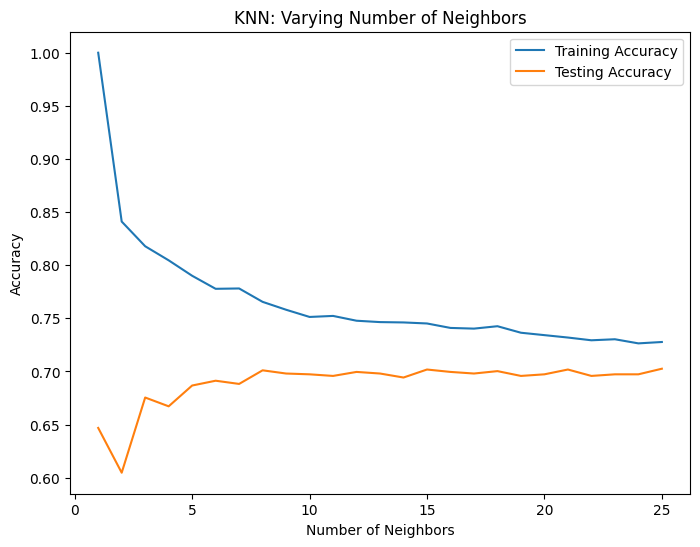

In [ ]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)
for neighbor in neighbors:
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	knn.fit(X_train, y_train)
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)

plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

# Support Vector Machine

In [ ]:
supportvm = svm.SVC(kernel='linear')
supportvm.fit(X_train, y_train)
y_pred = supportvm.predict(X_test)
accuracy_score( y_pred, y_test)

0.7748493975903614

# Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
accuracy_score(y_pred, y_test)

0.6769578313253012

# Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_pred, y_test)


0.6731927710843374

# Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=4, criterion='gini', n_estimators=10);
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.7341867469879518

# Ensemble

In [ ]:
vote = VotingClassifier(estimators=[('knn', knn), ('supportvm', supportvm), ('dt', dt), ('rf', rf), ('nb', nb)])
vote.fit(X_train, y_train)
y_pred = vote.predict(X_test)
accuracy_score(y_test, y_pred)

0.7560240963855421